<a href="https://colab.research.google.com/github/ThomasKoutsikos/Machine_Learning_for_Many_Body_Physics_Homework_1/blob/main/Machine_Learning_Homework_1_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Classifying phases of the Ising model using neural networks

PSI 2023-2024

Machine Learning for Many-Body Physics

April 25, 2024

Original Code by Lauren Hayward, Juan Carrasquilla, and Mohamed Hibat Allah

## Create the data set


In [41]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu' #To use GPUs in PyTorch

!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/x_L30.txt
!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/y_L30.txt
!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/T_L30.txt

--2024-04-26 19:25:25--  https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/x_L30.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18000000 (17M) [text/plain]
Saving to: ‘x_L30.txt.8’

x_L30.txt.8         100%[===================>]  17.17M  --.-KB/s    in 0.09s   

2024-04-26 19:25:26 (190 MB/s) - ‘x_L30.txt.8’ saved [18000000/18000000]

--2024-04-26 19:25:26--  https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/y_L30.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request

# Read the data

In [42]:
x_all     = np.loadtxt( 'x_L30.txt', dtype='int16' )
y_all     = np.loadtxt( 'y_L30.txt', dtype='int16' )
T_all     = np.loadtxt( 'T_L30.txt', dtype='int16' )
L=30 #Lattice Size
N_con=10000 #Number of configurations

indices_shuffled = np.random.permutation(N_con)
x_all = x_all[indices_shuffled,:]
y_all = y_all[indices_shuffled]
T_all = T_all[indices_shuffled]

N_train = int(0.7*N_con)
x_train = x_all[0:N_train,:]
y_train = y_all[0:N_train]

N_validation = int(0.2*N_con)
x_validation = x_all[N_train:N_train+N_validation,:]
y_validation = y_all[N_train:N_train+N_validation]

N_test = int(0.1*N_con)
x_test = x_all[N_train+N_validation:,:]
y_test = y_all[N_train+N_validation:]

<ipython-input-42-a21d4a8a09e2>:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  T_all     = np.loadtxt( 'T_L30.txt', dtype='int16' )


## Define the network architecture and training hyperparameters

In [43]:
%matplotlib inline
from IPython import display

import time
import torch

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size,100)
        self.linear2 = torch.nn.Linear(100,self.output_size)

        self.relu    = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        a1 = self.sigmoid(linear1_out)
        #Layer 2:
        linear2_out = self.linear2(a1)
        a2 = self.softmax(linear2_out)

        #Network output:
        aL = a2

        return aL

input_size = 30*30
output_size = 2
model = FeedforwardNN(input_size, output_size).to(device)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float).to(device)
x_validation = torch.tensor(x_validation, dtype = torch.float).to(device)
### One hot encoding ###
y_onehot = np.zeros((y_train.size, 2))
y_onehot[np.arange(y_train.size),y_train] = 1
y_onehot = torch.tensor(y_onehot, dtype = torch.float).to(device)
### One hot encoding for validation###
y_onehot_val = np.zeros((y_validation.size, 2))
y_onehot_val[np.arange(y_validation.size),y_validation] = 1
y_onehot_val = torch.tensor(y_onehot_val, dtype = torch.float).to(device)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 0.15
wd = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)

### Cost function: ###
cost_func = torch.nn.MSELoss().to(device)
#cost_func = torch.nn.CrossEntropyLoss()
N_epochs = 100 # number of times to run gradient descent


## Training

Final Training cost 0.218482
Final Validation cost 0.218393
Final Training accuracy 0.961429
Final Validation accuracy 0.964000



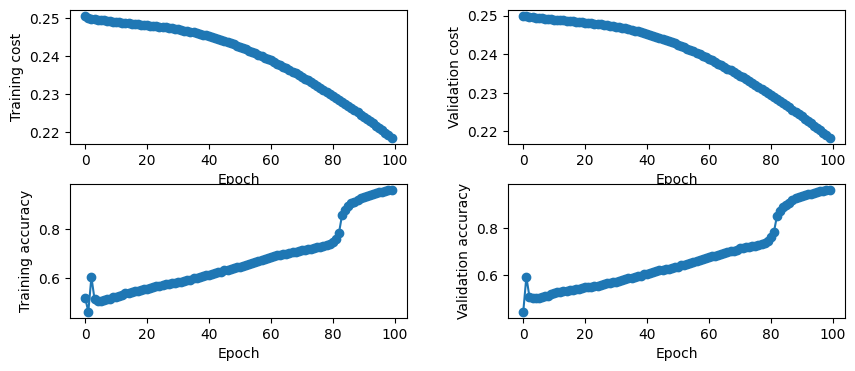

In [44]:
epoch_list    = []
cost_training = []
cost_validation = []
acc_training  = []
acc_validation  = []
final_accuracy = np.zeros(10)

for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output_training = model(x_train) # Neural network output
    cost_train = cost_func(NN_output_training, y_onehot)
    cost_train.backward() #computes the gradients
    optimizer.step() #updating the parameters

    cost_train = cost_func(NN_output_training, y_onehot).cpu().detach().numpy()
    predicted_class = np.argmax(NN_output_training.cpu().detach().numpy(), axis=1)
    training_accuracy = np.mean(predicted_class == y_train)


    NN_output_validation = model(x_validation) # Neural network output
    cost_val = cost_func(NN_output_validation, y_onehot_val).cpu().detach().numpy()
    predicted_class = np.argmax(NN_output_validation.cpu().detach().numpy(), axis=1)
    accuracy_validation = np.mean(predicted_class == y_validation)

    epoch_list.append(epoch)
    cost_training.append(cost_train)
    cost_validation.append(cost_val)
    acc_validation.append(accuracy_validation)
    acc_training.append(training_accuracy)

    fig = plt.figure(1,figsize=(10,4))
    fig.subplots_adjust(hspace=.3,wspace=.3)
    plt.clf()

    ### Plot the cost function during training: ###
    plt.subplot(221)
    plt.plot(epoch_list,cost_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the cost function during validation: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_validation,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Validation cost')

    ### Plot the training accuracy: ###
    plt.subplot(223)
    plt.plot(epoch_list,acc_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')

    ### Plot the validation accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_validation,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Validation accuracy')
    #plt.pause(0.1)
    display.display(plt.gcf())
    print( "Epoch %d:\n  Training cost %f\n Validation cost %f\n Training accuracy %f\n  Validation accuracy %f\n" % (epoch, cost_train,cost_val,training_accuracy,accuracy_validation) )
    display.clear_output(wait=True)

plt.savefig('Training_Results_WD0001.pdf', bbox_inches="tight")
print("Final Training cost %f\nFinal Validation cost %f\nFinal Training accuracy %f\nFinal Validation accuracy %f\n" % (cost_train,cost_val,training_accuracy ,accuracy_validation) )




In [45]:
#Run this cell if you want to save a pdf plot of the results:
files.download('Training_Results_WD0001.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

With a regularization hyperparameter of 0.01 we observe that the plateu is reached at a later epoch in a smoother way than without L2. The final values for the training and validation accuracy are slightly less than without L2. (around 0.984).

Increasing the hyperparameter to 0.1 we observe significant qualitative differences. The model is over-regularised as it seems, because as we can see in the training accuracy and validation accuracy plots we arrive at a lower plateu at an earlier epoch and then the accuracy starts to fall.

Decreasing the hyperparameter to 0.001 we observe results similar to 0.01, with the difference that we have not quite arrived at the plateu, which is apparent  both form the lower accuracy of 0.964 but primarily from the plots.